# Detecting burger menu

## Setup

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import albumentations as A
import os
import cv2
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import albumentations as A
from yolov7 import create_yolov7_model, create_yolov7_loss
from yolov7.trainer import Yolov7Trainer, filter_eval_predictions
from yolov7.dataset import Yolov7Dataset, yolov7_collate_fn, create_yolov7_transforms
from yolov7.evaluation import CalculateMeanAveragePrecisionCallback
from pytorch_accelerated.schedulers import CosineLrScheduler
from pytorch_accelerated.callbacks import (
    EarlyStoppingCallback,
    SaveBestModelCallback,
    get_default_callbacks,
)
from functools import partial

INFO:pytorch_accelerated:Setting random seeds


In [2]:
torch.cuda.is_available()

True

In [3]:
df = pd.read_csv("rico/burger.csv")
df

,image_id,image,split,has_annotation,xmin,ymin,xmax,ymax,class_id,class_name
0,12321,12321.jpg,train,True,0.0,63.0,147.00,210.00,0.0,burger
1,65445,65445.jpg,train,True,10.5,73.5,136.50,199.50,0.0,burger
2,56899,56899.jpg,train,True,0.0,63.0,131.25,194.25,0.0,burger
3,4850,4850.jpg,train,True,0.0,52.5,21.00,73.50,0.0,burger
4,56149,56149.jpg,train,True,0.0,63.0,147.00,210.00,0.0,burger
...,...,...,...,...,...,...,...,...,...,...
14167,18937,18937.jpg,train,False,NaN,NaN,NaN,NaN,NaN,background
14168,14823,14823.jpg,train,False,NaN,NaN,NaN,NaN,NaN,background
14169,32978,32978.jpg,val,False,NaN,NaN,NaN,NaN,NaN,background
14170,58932,58932.jpg,train,False,NaN,NaN,NaN,NaN,NaN,background


## Dataset

In [4]:
class BurgerDatasetAdaptor(Dataset):
    def __init__(
        self,
        images_dir_path,
        annotations_dataframe,
        transforms=None,
    ):
        self.images_dir_path = images_dir_path
        self.annotations_df = annotations_dataframe
        self.transforms = transforms

        self.image_idx_to_image_id = {
            idx: image_id
            for idx, image_id in enumerate(self.annotations_df.image_id.unique())
        }
        self.image_id_to_image_idx = {
            v: k for k, v, in self.image_idx_to_image_id.items()
        }

    def __len__(self) -> int:
        return len(self.image_idx_to_image_id)

    def __getitem__(self, index):
        image_id = self.image_idx_to_image_id[index]
        image_info = self.annotations_df[self.annotations_df.image_id == image_id]
        file_name = image_info.image.values[0]
        assert image_id == image_info.image_id.values[0]

        image = Image.open(os.path.join(self.images_dir_path, file_name)).convert("RGB")
        image = np.array(image)

        image_hw = image.shape[:2]

        if image_info.has_annotation.any():
            xyxy_bboxes = image_info[["xmin", "ymin", "xmax", "ymax"]].values
            class_ids = image_info["class_id"].values
        else:
            xyxy_bboxes = np.array([])
            class_ids = np.array([])

        if self.transforms is not None:
            transformed = self.transforms(
                image=image, bboxes=xyxy_bboxes, labels=class_ids
            )
            image = transformed["image"]
            xyxy_bboxes = np.array(transformed["bboxes"])
            class_ids = np.array(transformed["labels"])

        return image, xyxy_bboxes, class_ids, image_id, image_hw

In [5]:
train_ds = BurgerDatasetAdaptor("rico/combined/", df[df["split"]=="train"])
val_ds = BurgerDatasetAdaptor("rico/combined/", df[df["split"]=="val"])
print(len(train_ds), len(val_ds))

10362 2585


In [6]:
# Plot numpy array
def plot_image(img, image_id):
    plt.axis('off')
    plt.imshow(img)
    plt.title(image_id)

# draw a single bounding box onto a numpy array image
def draw_bounding_box(img, annotation):
    if not annotation.any():
        return

    x_min, y_min = int(annotation[0]), int(annotation[1])
    x_max, y_max = int(annotation[2]), int(annotation[3])
    color = (255,0,0)
    
    cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

# draw all annotation bounding boxes on an image
def annotate_image(img, boxes):
    for box in boxes:
        draw_bounding_box(img, box)

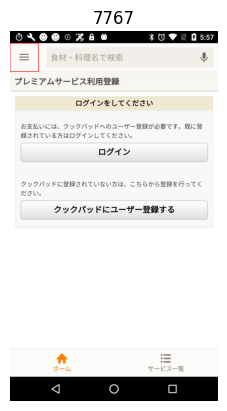

In [10]:
randidx = random.randint(0,len(train_ds))
image, xyxy_boxes, class_ids, image_id, image_hw = train_ds[randidx]
annotate_image(image, xyxy_boxes)
plot_image(image, image_id)

In [39]:
yolo_train_ds = Yolov7Dataset(train_ds, create_yolov7_transforms(training=True))
yolo_val_ds = Yolov7Dataset(train_ds, create_yolov7_transforms())

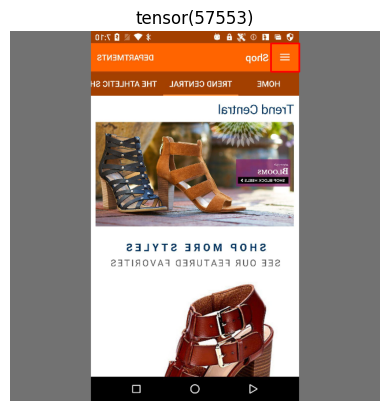

In [45]:
image_tensor, labels, image_id, image_size = yolo_train_ds[randidx]

boxes = labels[:, 2:]
boxes *= 640
boxes = torchvision.ops.box_convert(
    torch.as_tensor(boxes, dtype=torch.float32), "cxcywh", "xyxy"
)

boxes = boxes.numpy()
image = image_tensor.permute(1, 2, 0).numpy()

annotate_image(image, boxes)
plot_image(image, image_id)

In [46]:
model = create_yolov7_model('yolov7', num_classes=1, pretrained=True)
criterion = create_yolov7_loss(model, image_size=640)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

Transferred 555/566 items from https://github.com/Chris-hughes10/Yolov7-training/releases/download/0.1.0/yolov7_training_state_dict.pt


## Training

In [47]:
trainer = Yolov7Trainer(
    model=model,
    optimizer=optimizer,
    loss_func=criterion,
    filter_eval_predictions_fn=partial(
        filter_eval_predictions, confidence_threshold=0.01, nms_threshold=0.3
    ),
    callbacks=[
        CalculateMeanAveragePrecisionCallback.create_from_targets_df(
            targets_df=df[df["split"]=="val"].query("has_annotation == True")[
                ["image_id", "xmin", "ymin", "xmax", "ymax", "class_id"]
            ],
            image_ids=set(df[df["split"]=="val"].image_id.unique()),
            iou_threshold=0.2,
        ),
        SaveBestModelCallback(watch_metric="map", greater_is_better=True),
        EarlyStoppingCallback(
            early_stopping_patience=3,
            watch_metric="map",
            greater_is_better=True,
            early_stopping_threshold=0.001,
        ),
        *get_default_callbacks(progress_bar=True),
    ],
)

In [ ]:
num_epochs = 30
batch_size = 4

trainer.train(
    num_epochs=num_epochs,
    train_dataset=yolo_train_ds,
    eval_dataset=yolo_val_ds,
    per_device_batch_size=batch_size,
    create_scheduler_fn=CosineLrScheduler.create_scheduler_fn(
        num_warmup_epochs=5,
        num_cooldown_epochs=5,
        k_decay=2,
    ),
    collate_fn=yolov7_collate_fn,
)